In [27]:
import xarray as xr
import salem
import geopandas as gpd

In [28]:
import sys
sys.path.append('../scripts/')
from Model import *
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *

In [29]:
def retrieveFile(model, variable, metric, **kwargs):
    m = NEXModel(f='',
                parse_details=False,
                model='IMD',
                variable=variable,
                scen='observation',
                model_type='Observation')
    
    m.outdir = '/media/abhi/My_Passport/NEX-GDDP-NASA-PROCESSED'
    return(m.retrieve(metric=metric, **kwargs))

In [11]:
!ncview {retrieveFile('IMD', 'pr','monmean', year_str='1976-2005')}

Ncview 2.1.6 David W. Pierce  29 Oct 2015
http://meteora.ucsd.edu:80/~pierce/ncview_home_page.html
Copyright (C) 1993 through 2015, David W. Pierce
Ncview comes with ABSOLUTELY NO WARRANTY; for details type `ncview -w'.
This is free software licensed under the Gnu General Public License version 3; type `ncview -c' for redistribution details.

calculating min and maxes for pr...
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 1221 requests (1221 known processed) with 0 events remaining.


In [30]:
model = 'IMD'

In [31]:
dset_dict = {variable: monmean(xr.open_dataset(retrieveFile(model, variable, 
                                                    'monmean', 
                                                    year_str='1976-2005'))[variable])
             for variable in variables}

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [33]:
dset_dictp = {k: v.sel(lon=77.75, lat=20.9, method='nearest') for k, v in dset_dict.items()}

In [34]:
dset_dictp

{'pr': <xarray.DataArray 'pr' (time: 360)>
 array([0.024217, 0.      , 0.539316, ..., 1.80818 , 0.      , 0.004954],
       dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1976-01-31 1976-02-29 ... 2005-12-31
     lon      float64 77.75
     lat      float64 21.0, 'tas': <xarray.DataArray 'tas' (time: 360)>
 array([20.47429 , 24.017334, 28.401127, ..., 25.431185, 22.05147 , 20.244919],
       dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1976-01-31 1976-02-29 ... 2005-12-31
     lon      float64 77.5
     lat      float64 20.5, 'tasmax': <xarray.DataArray 'tasmax' (time: 360)>
 array([28.29218 , 32.679893, 36.9065  , ..., 31.588293, 31.060856, 28.797113],
       dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1976-01-31 1976-02-29 ... 2005-12-31
     lon      float64 77.5
     lat      float64 20.5, 'tasmin': <xarray.DataArray 'tasmin' (time: 360)>
 array([12.656405, 15.354772, 19.895754, ..., 19.271095, 13.038267, 11.681108],
      

In [35]:
variableIndex = pd.Index(variables, name='variable')

In [36]:
ds = xr.concat(dset_dictp.values(), dim=variableIndex).to_dataset(name='value')

In [37]:
seasIndex = pd.Index(['Annual', 'DJF', 'MAM', 'JJAS', 'ON'], name='seas')

In [38]:
ds = xr.concat([yearmean(ds)] + [yearmean(selseas(ds, seas)) for seas in seasIndex[1:]],
                dim=seasIndex)

In [39]:
ds

<xarray.Dataset>
Dimensions:   (seas: 5, variable: 4, year: 30)
Coordinates:
    lon       (variable) float64 77.75 77.5 77.5 77.5
    lat       (variable) float64 21.0 20.5 20.5 20.5
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
  * year      (year) int64 1976 1977 1978 1979 1980 ... 2001 2002 2003 2004 2005
  * seas      (seas) object 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
Data variables:
    value     (seas, year, variable) float32 2.1643994 27.02243 ... 16.154682

In [42]:
import dask.array as da
from scipy import stats

def regression(y, axis='time'):
    axis_num = y.get_axis_num(axis)
    return da.apply_along_axis(_calc_slope, axis_num, y)

def _calc_slope(y):
    x = np.arange(len(y))
    return [stats.linregress(x, y).slope, stats.linregress(x, y).pvalue]

In [43]:
res = regression(ds.value, axis="year")

/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [44]:
res

dask.array<_calc_slope-along-axis, shape=(5, 2, 4), dtype=float64, chunksize=(5, 2, 4)>

In [45]:
statistics = ['trend', 'p_value']
coords = {'seas': seasIndex,
          'stats': statistics,
          'variable': variableIndex,}
#           'lat': ds.lat, 
#           'lon': ds.lon}

trend_ds = xr.Dataset({'value':
                     (coords.keys(),
                      res)}, coords = coords)

In [46]:
trend_ds

<xarray.Dataset>
Dimensions:   (seas: 5, stats: 2, variable: 4)
Coordinates:
  * seas      (seas) object 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * stats     (stats) <U7 'trend' 'p_value'
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
Data variables:
    value     (seas, stats, variable) float64 dask.array<shape=(5, 2, 4), chunksize=(5, 2, 4)>

In [47]:
trend_ds = trend_ds.compute()

In [48]:
trend_ds

<xarray.Dataset>
Dimensions:   (seas: 5, stats: 2, variable: 4)
Coordinates:
  * seas      (seas) object 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * stats     (stats) <U7 'trend' 'p_value'
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
Data variables:
    value     (seas, stats, variable) float64 -0.01548 -0.003915 ... 0.09572

In [49]:
significant_alpha = trend_ds.sel(stats='trend').where(trend_ds.sel(stats='p_value') < 0.1)

In [50]:
trend_ds

<xarray.Dataset>
Dimensions:   (seas: 5, stats: 2, variable: 4)
Coordinates:
  * seas      (seas) object 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * stats     (stats) <U7 'trend' 'p_value'
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
Data variables:
    value     (seas, stats, variable) float64 -0.01548 -0.003915 ... 0.09572

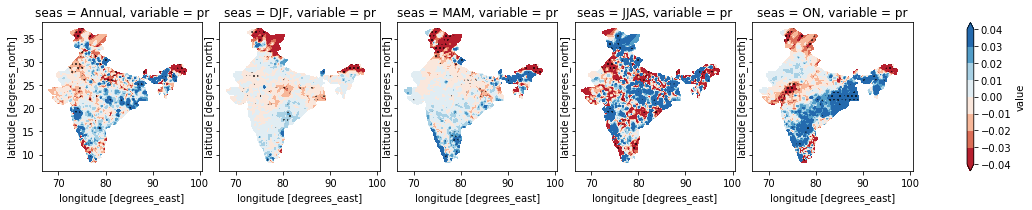

In [29]:
g = (trend_ds
     .sel(stats='trend', variable='pr')
     .value
     .plot
     .contourf(col='seas',
               levels=np.arange(-0.04, 0.05, 0.01),
               cmap='RdBu')
    )

# TODO: Plot this using g.map somehow?
for ax, seas in zip(g.axes.flatten(), seasIndex):
    (significant_alpha.value
         .sel(seas=seas, variable='pr')
         .plot.contourf(hatches=["..."], alpha=0, ax=ax, add_colorbar=False,
                       ))
    

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


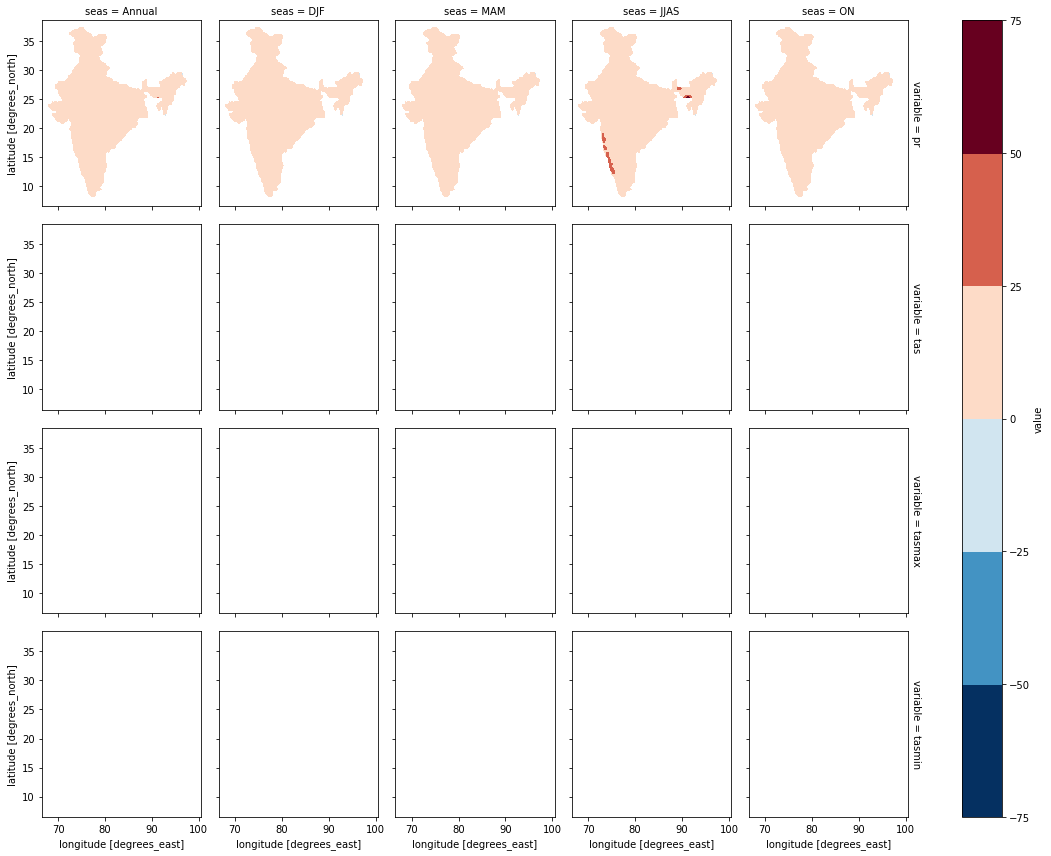

In [25]:
ds.value.mean(dim='year').plot.contourf(col='seas', row='variable')

In [40]:
df = ds.to_dataframe().reset_index()

In [41]:
df

seas variable  year    lon   lat      value
0    Annual       pr  1976  77.75  21.0   2.164399
1    Annual       pr  1977  77.75  21.0   2.533489
2    Annual       pr  1978  77.75  21.0   2.919976
3    Annual       pr  1979  77.75  21.0   3.353402
4    Annual       pr  1980  77.75  21.0   2.033607
5    Annual       pr  1981  77.75  21.0   2.915796
6    Annual       pr  1982  77.75  21.0   2.077565
7    Annual       pr  1983  77.75  21.0   2.765596
8    Annual       pr  1984  77.75  21.0   2.412825
9    Annual       pr  1985  77.75  21.0   2.095295
10   Annual       pr  1986  77.75  21.0   2.068702
11   Annual       pr  1987  77.75  21.0   1.649694
12   Annual       pr  1988  77.75  21.0   3.260504
13   Annual       pr  1989  77.75  21.0   2.058269
14   Annual       pr  1990  77.75  21.0   3.336216
15   Annual       pr  1991  77.75  21.0   1.532784
16   Annual       pr  1992  77.75  21.0   2.513266
17   Annual       pr  1993  77.75  21.0   2.273770
18   Annual       pr  1994  77.75  21.0   3.029419
19   Annual       pr  1995  77.75  21.0   2.234715
20   Annual       pr  1996  77.75  21.0   1.895074
21   Annual       pr  1997  77.75  21.0   2.621671
22   Annual       pr  1998  77.75  21.0   2.248264
23   Annual       pr  1999  77.75  21.0   2.176944
24   Annual       pr  2000  77.75  21.0   2.261493
25   Annual       pr  2001  77.75  21.0   2.403568
26   Annual       pr  2002  77.75  21.0   1.815836
27   Annual       pr  2003  77.75  21.0   2.191892
28   Annual       pr  2004  77.75  21.0   1.540151
29   Annual       pr  2005  77.75  21.0   2.689365
..      ...      ...   ...    ...   ...        ...
570      ON   tasmin  1976  77.50  20.5  19.659962
571      ON   tasmin  1977  77.50  20.5  19.473465
572      ON   tasmin  1978  77.50  20.5  19.288784
573      ON   tasmin  1979  77.50  20.5  20.347094
574      ON   tasmin  1980  77.50  20.5  18.878794
575      ON   tasmin  1981  77.50  20.5  17.530628
576      ON   tasmin  1982  77.50  20.5  19.184170
577      ON   tasmin  1983  77.50  20.5  16.267075
578      ON   tasmin  1984  77.50  20.5  17.197763
579      ON   tasmin  1985  77.50  20.5  16.786055
580      ON   tasmin  1986  77.50  20.5  18.576580
581      ON   tasmin  1987  77.50  20.5  18.990723
582      ON   tasmin  1988  77.50  20.5  17.187815
583      ON   tasmin  1989  77.50  20.5  18.167730
584      ON   tasmin  1990  77.50  20.5  18.733662
585      ON   tasmin  1991  77.50  20.5  17.793373
586      ON   tasmin  1992  77.50  20.5  18.241249
587      ON   tasmin  1993  77.50  20.5  18.583031
588      ON   tasmin  1994  77.50  20.5  18.432472
589      ON   tasmin  1995  77.50  20.5  18.315125
590      ON   tasmin  1996  77.50  20.5  17.928951
591      ON   tasmin  1997  77.50  20.5  19.912033
592      ON   tasmin  1998  77.50  20.5  19.707321
593      ON   tasmin  1999  77.50  20.5  18.181448
594      ON   tasmin  2000  77.50  20.5  18.504856
595      ON   tasmin  2001  77.50  20.5  17.971586
596      ON   tasmin  2002  77.50  20.5  17.603926
597      ON   tasmin  2003  77.50  20.5  18.249382
598      ON   tasmin  2004  77.50  20.5  17.472828
599      ON   tasmin  2005  77.50  20.5  16.154682

[600 rows x 6 columns]

In [26]:
dset_dict

{'pr': <xarray.DataArray 'pr' (time: 360, lat: 129, lon: 135)>
 array([[[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        ...,
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]],
 
        [[nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan],
         ...,
         [nan, nan, ..., nan, nan],
         [nan, nan, ..., nan, nan]]], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1976-01-31 1976-02-29 ... 2005-12-31
   * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
   * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5,
 'tas': <xarr